#Peak Prediction - Washington DC



In [416]:
#import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [417]:
cd drive/MyDrive/peak_prediction/

[Errno 2] No such file or directory: 'drive/MyDrive/peak_prediction/'
/content/drive/MyDrive/peak_prediction


In [418]:
ls

catboost_info/
daily_temperatures_impute_missing.csv
imputed_data.csv
japan.csv
kyoto.csv
liestal.csv
merged_kyoto.csv
merged_kyoto.gsheet
merged_kyoto_off.csv
merged_liestal.csv
merged_liestal.gsheet
merged_liestal_off.csv
merged_vancouver.csv
merged_vancouver.gsheet
merged_vancouver_off.csv
merged_washington_1.csv
merged_washington_co2_test.csv
merged_washington_co2_test_excel.csv
merged_washington_co2_test.gsheet
merged_washington.csv
merged_washington.gsheet
merged_washington_off.csv
merged_washington_test.csv
merged_washington_test_excel.csv
merged_washington_test.gsheet
meteoswiss.csv
README.md
south_korea.csv
USA-NPN_individual_phenometrics_data.csv
USA-NPN_individual_phenometrics_datafield_descriptions.csv
USA-NPN_status_intensity_datafield_descriptions.csv
USA-NPN_status_intensity_observations_data.csv
vancouver.csv
washingtondc.csv


In [419]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import LabelEncoder
import scipy.integrate as integrate
import xgboost as xgb
from xgboost import plot_tree
!pip install catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [420]:
df = pd.read_csv("merged_washington_off.csv")
YEARS = df.year
df.head()
print(df.dtypes)


lat                      float64
long                     float64
year                       int64
bloom_date                object
bloom_doy                  int64
cat_bloom_doy              int64
cat_bloom_doy_1_year     float64
cat_bloom_doy_2_years    float64
location                  object
month                    float64
season                    object
tmax_avg                 float64
tmax_max                 float64
tmin_avg                 float64
tmin_min                 float64
gdd_avg                  float64
prcp_avg                 float64
dtype: object


# 1. EDA

In [421]:
print(df.columns)
print()
min_date, max_date = df.bloom_doy.min(), df.bloom_doy.max()
print(f'Min bloom date = {min_date} days')
print(f'Max bloom date = {max_date} days')

"""1. Create hashmap: (bloom date class -> bloom date raw)"""
hm_bloom_date = {}
for idx, date in enumerate(range(min_date, max_date, 4)):
    hm_bloom_date[idx] = [date, date+3]
    print(hm_bloom_date[idx])

print(f"\tExample: class 0 is in range {hm_bloom_date[0]} days from Jan 1.")

df.head()

Index(['lat', 'long', 'year', 'bloom_date', 'bloom_doy', 'cat_bloom_doy',
       'cat_bloom_doy_1_year', 'cat_bloom_doy_2_years', 'location', 'month',
       'season', 'tmax_avg', 'tmax_max', 'tmin_avg', 'tmin_min', 'gdd_avg',
       'prcp_avg'],
      dtype='object')

Min bloom date = 74 days
Max bloom date = 106 days
[74, 77]
[78, 81]
[82, 85]
[86, 89]
[90, 93]
[94, 97]
[98, 101]
[102, 105]
	Example: class 0 is in range [74, 77] days from Jan 1.


,lat,long,year,bloom_date,bloom_doy,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years,location,month,season,tmax_avg,tmax_max,tmin_avg,tmin_min,gdd_avg,prcp_avg
0,38.88535,-77.038628,1960,1960-04-14,105,7,NaN,NaN,washingtondc,0.0,Winter,10.916129,18.3,0.432258,-8.9,5.674194,28.709677
1,38.88535,-77.038628,1960,1960-04-14,105,7,NaN,NaN,washingtondc,1.0,Winter,7.590323,15.0,-0.732258,-8.3,3.429032,24.000000
2,38.88535,-77.038628,1960,1960-04-14,105,7,NaN,NaN,washingtondc,2.0,Winter,8.034483,19.4,-0.744828,-7.8,3.644828,32.241379
3,38.88535,-77.038628,1960,1960-04-14,105,7,NaN,NaN,washingtondc,3.0,Spring,6.925806,27.2,-3.248387,-12.2,1.838710,15.732258
4,38.88535,-77.038628,1960,1960-04-14,105,7,NaN,NaN,washingtondc,4.0,Spring,23.946667,34.4,8.816667,-0.6,16.381667,27.866667


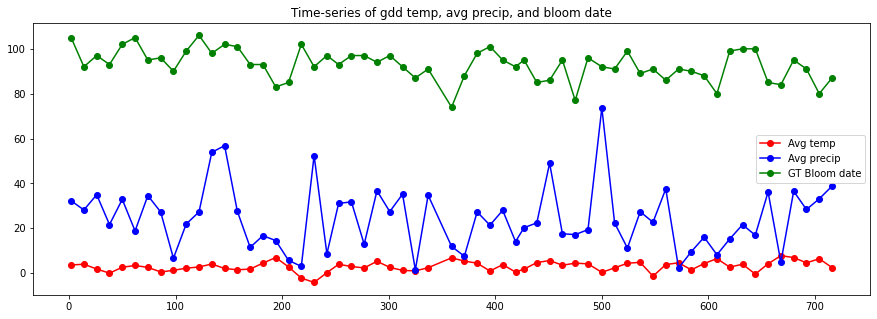

In [422]:
MONTH = 2
plt.figure(figsize=(15,5))
plt.title('Time-series of gdd temp, avg precip, and bloom date')
plt.plot(df[df.month == MONTH].gdd_avg, '-o', color='red', label='Avg temp')
plt.plot(df[df.month == MONTH].prcp_avg, '-o', color='blue', label='Avg precip')
plt.plot(df[df.month == MONTH].bloom_doy, '-o', color='green', label='GT Bloom date')
plt.legend()

# 2a. Split input & labels
## PLUS: reformat label according to prediction range

In [423]:
def split_XY(df, input_features, output_features):
    """Preprocess input data"""
    X = df[input_features]
    if 'cat_bloom_doy_last_year' in X:
        X = X.astype({'cat_bloom_doy_last_year': int}, errors = 'ignore')
        
    if 'cat_bloom_doy_last_2_years' in X:
        X = X.astype({'cat_bloom_doy_last_2_years': int}, errors = 'ignore')
        

    """Preprocess labels"""
    Y = df[output_features]

    return X, Y

# ??????
def remove_first_two_years(df, YEARS):
    """Start with years >= year_min + 2 because we shifted cat_bloom_doy column by 2"""
    df = df[df.year >= YEARS.min() + 2]
    try: df = df.dropna().reset_index()
    except: pass
    print(df.year.min())

    return df

"""
    Reformat the label to fit the prediction range (in years)
    E.g: shift(-5) if aims to predict 5 years ahead
"""
def reformat_labels(df, label_name, prediction_range):
    df[label_name] = df[label_name].shift(-12 * prediction_range)
    df = df.dropna().reset_index()
    return df

#Select prediction date here


In [424]:
"""Split input & labels"""
input_features = ['month', 'tmax_avg', 'tmax_max','tmin_avg', 'tmin_min',
                  'prcp_avg', 'gdd_avg', 'cat_bloom_doy','cat_bloom_doy_1_year', 'cat_bloom_doy_2_years']
output_features = ['bloom_doy'] # OR cat_bloom_doy
PREDICTION_RANGE = 11 #year

df = remove_first_two_years(df, YEARS)
original_df = df.copy()
df = reformat_labels(df, label_name=output_features, prediction_range=PREDICTION_RANGE)
display(df.tail(10))
X, Y = split_XY(df, input_features, output_features)
display(X.head(10))
display(Y.head(10))

1962


,level_0,index,lat,long,year,bloom_date,bloom_doy,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years,location,month,season,tmax_avg,tmax_max,tmin_avg,tmin_min,gdd_avg,prcp_avg
558,558,583,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,1.0,Winter,5.441935,18.900000,-3.829032,-12.20,0.806452,20.161290
559,559,584,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,2.0,Winter,5.455293,18.114105,-2.537017,-12.20,1.459138,9.611312
560,560,585,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,3.0,Spring,14.645161,25.000000,4.535484,-1.10,9.590323,30.129032
561,561,586,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,4.0,Spring,22.200470,33.300000,8.842725,3.30,15.521598,14.156529
562,562,587,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,5.0,Spring,25.361290,33.300000,14.025806,5.00,19.693548,21.516129
563,563,588,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,6.0,Summer,31.630000,36.100000,20.746667,15.00,26.188333,15.333333
564,564,589,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,7.0,Summer,31.393813,38.300000,20.739791,5.67,26.066802,30.599733
565,565,590,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,8.0,Summer,30.916129,36.700000,20.793548,16.10,25.854839,50.258065
566,566,591,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,9.0,Fall,29.023333,35.600000,16.383333,9.40,22.703333,23.433333
567,567,592,38.88535,-77.038628,2010,2010-03-31,87.0,3,4.0,2.0,washingtondc,10.0,Fall,21.641290,30.000000,9.870000,3.30,15.755645,54.935484


,month,tmax_avg,tmax_max,tmin_avg,tmin_min,prcp_avg,gdd_avg,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years
0,0.0,7.151613,15.6,-1.458065,-8.9,19.377419,2.846774,5,4.0,7.0
1,1.0,6.912903,16.7,-2.932258,-13.9,12.041935,1.990323,5,4.0,7.0
2,2.0,6.417857,20.0,-2.742857,-14.4,34.964286,1.837500,5,4.0,7.0
3,3.0,12.470968,26.7,1.138710,-12.8,39.096774,6.804839,5,4.0,7.0
4,4.0,20.006667,31.7,7.850000,-2.2,29.833333,13.928333,5,4.0,7.0
5,5.0,27.438710,35.6,13.941935,3.3,35.161290,20.690323,5,4.0,7.0
6,6.0,29.060000,33.9,17.706667,13.9,28.966667,23.383333,5,4.0,7.0
7,7.0,30.054839,34.4,18.335484,13.3,12.903226,24.195161,5,4.0,7.0
8,8.0,31.580645,37.2,18.509677,13.3,5.322581,25.045161,5,4.0,7.0
9,9.0,25.710000,36.7,13.723333,4.4,26.166667,19.716667,5,4.0,7.0


,bloom_doy
0,101.0
1,101.0
2,101.0
3,101.0
4,101.0
5,101.0
6,101.0
7,101.0
8,101.0
9,101.0


# 2b. Split Train & Test set

In [425]:
def split_train_val_test(df, X, Y, train_months, TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT):
    assert TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1.0

    avail_years = df.year.unique()
    total_avail_years = len(avail_years)
    print(f'Total years = {total_avail_years} years')

    
    """Split Train / Val / Test years"""
    train_years = avail_years[: math.ceil(TRAIN_PERCENT*total_avail_years) ]
    val_years = avail_years[math.ceil(TRAIN_PERCENT*total_avail_years) : 
                            -math.ceil((TEST_PERCENT)*total_avail_years)]
    test_years = avail_years[-math.ceil((TEST_PERCENT)*total_avail_years) : ]
    print(f'Train years: {train_years}')
    print(f'Val years: {val_years}')
    print(f'Test years: {test_years}')
    assert len(train_years) + len(val_years) + len(test_years) == len(avail_years)

    """Get (X,Y) for train/val/test sets"""
    train_idx = df[(df.year >= train_years.min()) & (df.year <= train_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    val_idx = df[(df.year >= val_years.min()) & (df.year <= val_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    test_idx = df[(df.year >= test_years.min()) & (df.year <= test_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index

    X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
    X_val, Y_val = X.iloc[val_idx], Y.iloc[val_idx]
    X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]
    assert len(X_train) == len(Y_train) 
    assert len(X_val) == len(Y_val) 
    assert len(X_test) == len(X_test)

    return train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test

In [426]:
"""Train / Val / Test set ratio"""
TRAIN_PERCENT = 0.7
VAL_PERCENT = 0.15
TEST_PERCENT = 0.15
train_months = np.array([0,1,2])

train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test = split_train_val_test(df, X, Y, 
                                                                                                          train_months, 
                                                                                                          TRAIN_PERCENT, 
                                                                                                          VAL_PERCENT, 
                                                                                                          TEST_PERCENT)

Total years = 48 years
Train years: [1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995]
Val years: [1996 1997 1998 1999 2000 2001]
Test years: [2003 2004 2005 2006 2007 2008 2009 2010]


# 3. Model

In [427]:
"""3a. Data preparation"""
X_train, X_val, X_test = round(X_train, 3), round(X_val, 3), round(X_test, 3)
X_train.head()

,month,tmax_avg,tmax_max,tmin_avg,tmin_min,prcp_avg,gdd_avg,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years
0,0.0,7.152,15.6,-1.458,-8.9,19.377,2.847,5,4.0,7.0
1,1.0,6.913,16.7,-2.932,-13.9,12.042,1.990,5,4.0,7.0
2,2.0,6.418,20.0,-2.743,-14.4,34.964,1.838,5,4.0,7.0
12,0.0,5.365,18.9,-4.490,-13.9,27.935,0.437,4,5.0,4.0
13,1.0,5.661,15.6,-4.648,-16.7,11.742,0.506,4,5.0,4.0


In [428]:
# cat_features = [0, 7, 8]
# catboost_model = CatBoostRegressor(iterations=200, 
#                                    learning_rate=1, 
#                                    reg_lambda = 40,
#                                    subsample = 0.8,
#                                    random_strength = 20,
#                                    cat_features = cat_features,
#                                    loss_function='RMSE')

# """FIT BASE MODEL"""
# catboost_model.fit(X_train, Y_train, 
#                    use_best_model = True,
#                    eval_set = (X_val, Y_val))

In [429]:
xgb_model = xgb.XGBRegressor(n_estimators = 400,
                                max_depth = 3,
                                learning_rate = 0.1,
                                reg_lambda = 40,
                                objective = 'reg:squarederror',
                                early_stopping_rounds = 40)
xgb_model.fit(X_train, Y_train, 
              eval_set = [(X_train, Y_train), (X_val, Y_val)],
              verbose = False)

XGBRegressor(early_stopping_rounds=40, n_estimators=400,
             objective='reg:squarederror', reg_lambda=40)

In [430]:
"""
    Use ensemble of multiple months for prediction
    -> average prediction of each month
"""
print(f'Months used for predictions: {train_months}')
print(f'Prediction range: {PREDICTION_RANGE}')
preds = xgb_model.predict(X_test)
preds = preds.reshape(-1, len(train_months))

preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)

ground_truths = np.array(Y_test).flatten()
ground_truths = ground_truths.reshape(-1, len(train_months))
ground_truths = ground_truths[:,1].astype(int)

# print("Test years:\n", test_years)
# print("Predictions:\n", preds)
# print("Ground-truth:\n", ground_truths)

rmse = np.sqrt(MSE(ground_truths, preds))
mae = MAE(ground_truths, preds)
print("RMSE : % .2f" %(rmse))
print("MAE : % .2f" %(mae))

print('='*50)
for i in range(len(test_years)):
    print(f'Prediction for {test_years[i]}: {preds[i]}')
    print(f'     Label for {test_years[i]}: {ground_truths[i]}')
    print('='*50)

Months used for predictions: [0 1 2]
Prediction range: 11
RMSE :  10.31
MAE :  8.38
Prediction for 2003: 79
     Label for 2003: 100
Prediction for 2004: 93
     Label for 2004: 100
Prediction for 2005: 95
     Label for 2005: 85
Prediction for 2006: 91
     Label for 2006: 84
Prediction for 2007: 95
     Label for 2007: 95
Prediction for 2008: 89
     Label for 2008: 91
Prediction for 2009: 92
     Label for 2009: 80
Prediction for 2010: 79
     Label for 2010: 87


In [431]:
"""
    PREDICT 2033? 
    1. TRAIN MODEL WITH 12-YEAR RANGE 
    2. USE THIS MODEL ON 2021 DATA TO PREDICT 2033 (2033 = 2021 + 12)
"""
YEAR_USED = 2021
temp_df = original_df[original_df.year == YEAR_USED]
input_data, _ = split_XY(temp_df, input_features, output_features)
input_data = input_data[ input_data.month.isin(train_months) ]

print(f"Year in use = {YEAR_USED}")
print(f"Prediction Range = {PREDICTION_RANGE}")
print(f'Predicted year = {YEAR_USED + PREDICTION_RANGE}')

preds = xgb_model.predict(input_data)

"""Ensemble predictions from different months"""
preds = preds.reshape(-1, len(train_months))
preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)[0]
print(f"Predicted bloom date for year {YEAR_USED + PREDICTION_RANGE} = {preds}")

Year in use = 2021
Prediction Range = 11
Predicted year = 2032
Predicted bloom date for year 2032 = 92


In [432]:
# cherry = pd.concat([dc,kyoto,liestal])
# cherry.head()

In [433]:
# n_by_country = cherry.groupby("location")
# n_by_country.head()